In [21]:
import pandas as pd

heart_file_path = 'cardio_data_processed.csv'
raw_df = pd.read_csv(heart_file_path)
raw_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bp_category,bp_category_encoded
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120,Hypertension Stage 1,Hypertension Stage 1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679,Hypertension Stage 2,Hypertension Stage 2
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51,23.507805,Hypertension Stage 1,Hypertension Stage 1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479,Hypertension Stage 2,Hypertension Stage 2
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47,23.011177,Normal,Normal


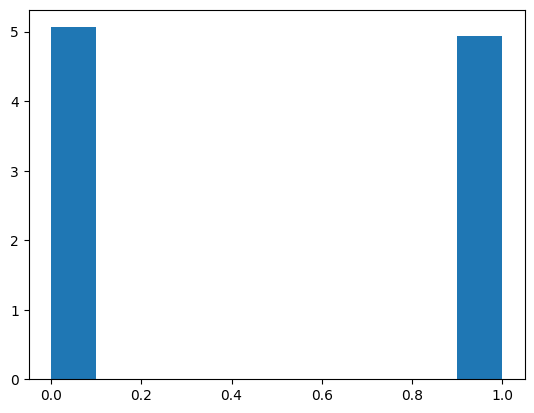

In [22]:
import matplotlib.pyplot as plt

plt.hist(raw_df['cardio'], density=1)
plt.show()
# dataset balanceado

In [23]:
# get target values and corresponding ids
df_targets_with_ids = raw_df[['id', 'cardio']]

# remove ids, bp_category_encoded, age (days version) and targets
# bp_category_encoded was supposed to be bp_category with proper proccessing for ML but it is not, so we can just drop it

df = raw_df.drop(columns=['id', 'age', 'cardio', 'bp_category_encoded'])
df.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,bmi,bp_category
0,2,168,62.0,110,80,1,1,0,0,1,50,21.967120,Hypertension Stage 1
1,1,156,85.0,140,90,3,1,0,0,1,55,34.927679,Hypertension Stage 2
2,1,165,64.0,130,70,3,1,0,0,0,51,23.507805,Hypertension Stage 1
3,2,169,82.0,150,100,1,1,0,0,1,48,28.710479,Hypertension Stage 2
4,1,156,56.0,100,60,1,1,0,0,0,47,23.011177,Normal


**Adjust bp_category for model input**

- bp_category: blood pressure category based from ap_hi and ap_lo: "Normal", "Elevated", "Hypertension Stage 1", "Hypertension Stage 2" and  "Hypertensive Crisis"

In [24]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
categorical_variables = df[['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bp_category']]

encoded_categoricals = ordinal_encoder.fit_transform(categorical_variables)
print(encoded_categoricals)

[[1. 0. 0. ... 0. 1. 1.]
 [0. 2. 0. ... 0. 1. 2.]
 [0. 2. 0. ... 0. 0. 1.]
 ...
 [1. 2. 0. ... 1. 0. 2.]
 [0. 0. 1. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 1. 1.]]


In [25]:
from sklearn.preprocessing import MinMaxScaler

# OBS: mimaxscaler fit_transform() deve ser usado  apenas em dados de TREINO! Para dados de teste usamos apenas o transform()
minmaxscaler = MinMaxScaler()
numeric_variables = df[['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']]

encoded_numericals = minmaxscaler.fit_transform(numeric_variables)
print(encoded_numericals)

[[0.57948718 0.26984127 0.22222222 0.33333333 0.6        0.06265466]
 [0.51794872 0.39153439 0.55555556 0.5        0.74285714 0.10655976]
 [0.56410256 0.28042328 0.44444444 0.16666667 0.62857143 0.06787388]
 ...
 [0.65641026 0.4973545  1.         0.5        0.65714286 0.09445216]
 [0.55384615 0.32275132 0.5        0.33333333 0.91428571 0.08004023]
 [0.58974359 0.32275132 0.33333333 0.33333333 0.77142857 0.07263578]]


Sum everything to get preproccessed dataset

In [26]:
df_encoded_num = pd.DataFrame(encoded_numericals, columns=numeric_variables.columns)

df_encoded_cat = pd.DataFrame(encoded_categoricals, columns=categorical_variables.columns)

# Concatenate the two DataFrames side-by-side (axis=1)
df_processed = pd.concat([df_encoded_num, df_encoded_cat], axis=1)

print(df_processed.head())

     height    weight     ap_hi     ap_lo  age_years       bmi  gender  \
0  0.579487  0.269841  0.222222  0.333333   0.600000  0.062655     1.0   
1  0.517949  0.391534  0.555556  0.500000   0.742857  0.106560     0.0   
2  0.564103  0.280423  0.444444  0.166667   0.628571  0.067874     0.0   
3  0.584615  0.375661  0.666667  0.666667   0.542857  0.085498     1.0   
4  0.517949  0.238095  0.111111  0.000000   0.514286  0.066192     0.0   

   cholesterol  gluc  smoke  alco  active  bp_category  
0          0.0   0.0    0.0   0.0     1.0          1.0  
1          2.0   0.0    0.0   0.0     1.0          2.0  
2          2.0   0.0    0.0   0.0     0.0          1.0  
3          0.0   0.0    0.0   0.0     1.0          2.0  
4          0.0   0.0    0.0   0.0     0.0          3.0  


**Create Pipeline for K-fold cross-validation**
1. Pre proccess data

In [27]:
from sklearn.compose import ColumnTransformer

X = raw_df
y = raw_df["cardio"]

numerical_cols = ['height', 'weight', 'ap_hi', 'ap_lo', 'age_years', 'bmi']
nominal_cols = ['gender', 'cholesterol', 'smoke', 'alco', 'active']
ordinal_cols = ['gluc', 'bp_category']

# Define order for ordinal features
ord_categories = [
    [1, 2, 3],
    ['Normal', "Elevated", "Hypertension Stage 1", "Hypertension Stage 2", "Hypertensive Crisis"]
]

# cleaner way of doing column preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_cols),
        ("cat", OrdinalEncoder(handle_unknown="error"), nominal_cols),
        ("ord", OrdinalEncoder(categories=ord_categories), ordinal_cols)
    ]
)

**2. Select and evaluate models**

TODO:
- poda de arvore
- mais variações de split no Kfold
- teste com menos atributos
- plottar graficos de resultados e matrizes de confusão para cada algoritmo

In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

**Decision Trees**

In [40]:
from sklearn.tree import DecisionTreeClassifier

models = {
    "gini": {
        "metric": "gini"
    },
    "entropy": {
        "metric": "entropy"
    }
}

results_tree = {}

for name, model in models.items():
    classifier = DecisionTreeClassifier(random_state=42, criterion=model["metric"])
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", classifier)
    ])
    acc = cross_val_score(pipe, X, y, cv=kfold, scoring="accuracy")
    prec = cross_val_score(pipe, X, y, cv=kfold, scoring="precision")
    rec = cross_val_score(pipe, X, y, cv=kfold, scoring="recall")
    f1 = cross_val_score(pipe, X, y, cv=kfold, scoring="f1")
    results_tree[name] = {
        "model": name,
        "accuracy_mean": acc.mean(),
        "accuracy_std": acc.std(),
        "precision_mean": prec.mean(),
        "precision_std": prec.std(),
        "recall_mean": rec.mean(),
        "recall_std": rec.std(),
        "f1_mean": f1.mean(),
        "f1_std": f1.std(),
    }

df_results_tree = pd.DataFrame(results_tree)
results["tree"] = df_results_tree
print(df_results_tree)

                    gini   entropy
model               gini   entropy
accuracy_mean   0.635115  0.637974
accuracy_std    0.004433  0.004337
precision_mean   0.63396  0.636298
precision_std   0.005238   0.00553
recall_mean     0.617456  0.622683
recall_std      0.005415  0.004351
f1_mean         0.625583  0.629398
f1_std           0.00429  0.003547


**Naive Bayes**

In [41]:
from sklearn.naive_bayes import GaussianNB

results_bayes = {}
classifier = GaussianNB()
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", classifier)
])
acc = cross_val_score(pipe, X, y, cv=kfold, scoring="accuracy")
prec = cross_val_score(pipe, X, y, cv=kfold, scoring="precision")
rec = cross_val_score(pipe, X, y, cv=kfold, scoring="recall")
f1 = cross_val_score(pipe, X, y, cv=kfold, scoring="f1")
results_bayes["naive_bayes"] = {
    "model": "naive bayes",
    "accuracy_mean": acc.mean(),
    "accuracy_std": acc.std(),
    "precision_mean": prec.mean(),
    "precision_std": prec.std(),
    "recall_mean": rec.mean(),
    "recall_std": rec.std(),
    "f1_mean": f1.mean(),
    "f1_std": f1.std(),
}

df_results_bayes = pd.DataFrame(results_bayes)
results["naive_bayes"] = df_results_bayes
print(df_results_bayes)

                naive_bayes
model           naive bayes
accuracy_mean      0.714537
accuracy_std       0.003299
precision_mean     0.748098
precision_std      0.003797
recall_mean        0.635899
recall_std         0.004664
f1_mean            0.687445
f1_std              0.00392


**KNN**

In [42]:
from sklearn.neighbors import KNeighborsClassifier

# p = 1 ---> manhattan
# p = 2 ---> euclidian

models = {
    "5": {
        "k": 5,
        "p": [1, 2]
    },
    "7": {
        "k": 7,
        "p": [1, 2]
    },
    "9": {
        "k": 9,
        "p": [1, 2]
    },
    "13": {
        "k": 13,
        "p": [1, 2]
    },
}

results_knn = {}

for name, model in models.items():
    for p in model["p"]:
        classifier = KNeighborsClassifier(n_neighbors=model["k"], p=p)
        pipe = Pipeline([
            ("preprocessor", preprocessor),
            ("model", classifier)
        ])
        acc = cross_val_score(pipe, X, y, cv=kfold, scoring="accuracy")
        prec = cross_val_score(pipe, X, y, cv=kfold, scoring="precision")
        rec = cross_val_score(pipe, X, y, cv=kfold, scoring="recall")
        f1 = cross_val_score(pipe, X, y, cv=kfold, scoring="f1")
        results_knn[name] = {
            "model": name,
            "distance": "euclidian" if p == 2 else "manhattan",
            "accuracy_mean": acc.mean(),
            "accuracy_std": acc.std(),
            "precision_mean": prec.mean(),
            "precision_std": prec.std(),
            "recall_mean": rec.mean(),
            "recall_std": rec.std(),
            "f1_mean": f1.mean(),
            "f1_std": f1.std(),
        }

    df_results_knn = pd.DataFrame(results_knn)
    results["knn"] = df_results_knn

print(df_results_knn)

                        5          7          9         13
model                   5          7          9         13
distance        euclidian  euclidian  euclidian  euclidian
accuracy_mean    0.695462   0.704816    0.71203   0.717425
accuracy_std      0.00256   0.002166   0.003385   0.004059
precision_mean   0.694984    0.70704   0.716423   0.725439
precision_std    0.004278   0.003726   0.004206   0.005579
recall_mean      0.682912   0.686624   0.689742   0.688109
recall_std       0.004013   0.002852   0.005673   0.005115
f1_mean          0.688876    0.69667   0.702813   0.706263
f1_std           0.001982   0.001558   0.003713    0.00395


**Logistic Regression**


In [43]:
from sklearn.linear_model import LogisticRegression

iters = [250, 500, 750, 1000]
results_logistic = {}

for iter in iters:
    classifier = LogisticRegression(max_iter=iter, random_state=42)
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", classifier)
    ])
    acc = cross_val_score(pipe, X, y, cv=kfold, scoring="accuracy")
    prec = cross_val_score(pipe, X, y, cv=kfold, scoring="precision")
    rec = cross_val_score(pipe, X, y, cv=kfold, scoring="recall")
    f1 = cross_val_score(pipe, X, y, cv=kfold, scoring="f1")
    results_logistic[name] = {
        "model": f"logistic{iter}",
        "accuracy_mean": acc.mean(),
        "accuracy_std": acc.std(),
        "precision_mean": prec.mean(),
        "precision_std": prec.std(),
        "recall_mean": rec.mean(),
        "recall_std": rec.std(),
        "f1_mean": f1.mean(),
        "f1_std": f1.std(),
    }

df_results_logistic = pd.DataFrame(results_logistic)
results["logistic"] = df_results_logistic
print(df_results_logistic)

                          13
model           logistic1000
accuracy_mean       0.726398
accuracy_std        0.001773
precision_mean      0.752782
precision_std       0.002788
recall_mean         0.663816
recall_std          0.002867
f1_mean             0.705499
f1_std              0.001895


3. Evaluate models

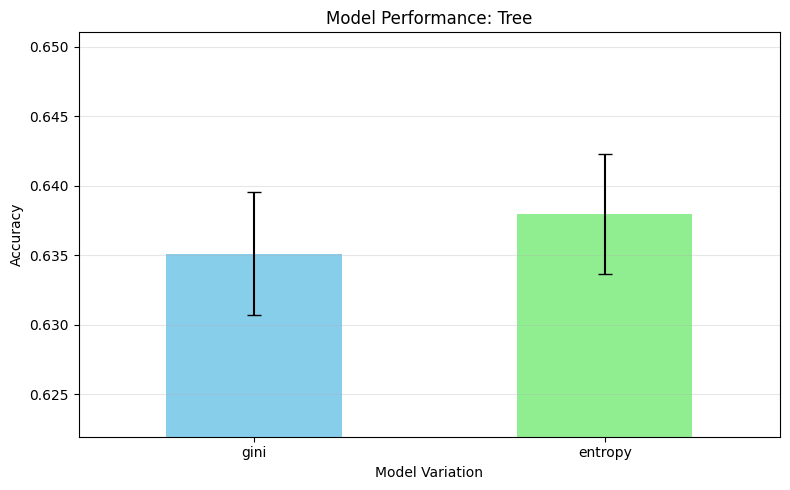

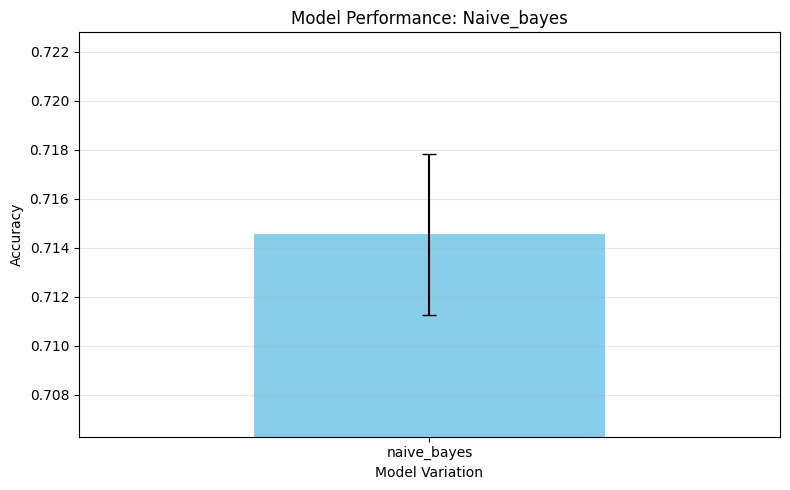

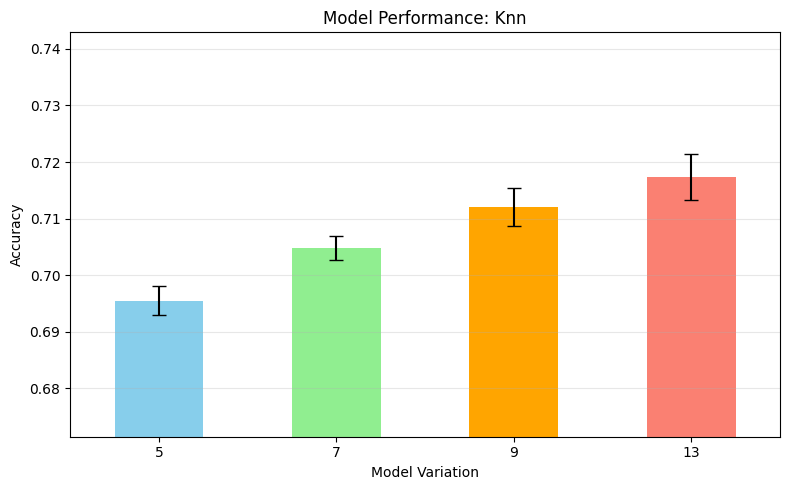

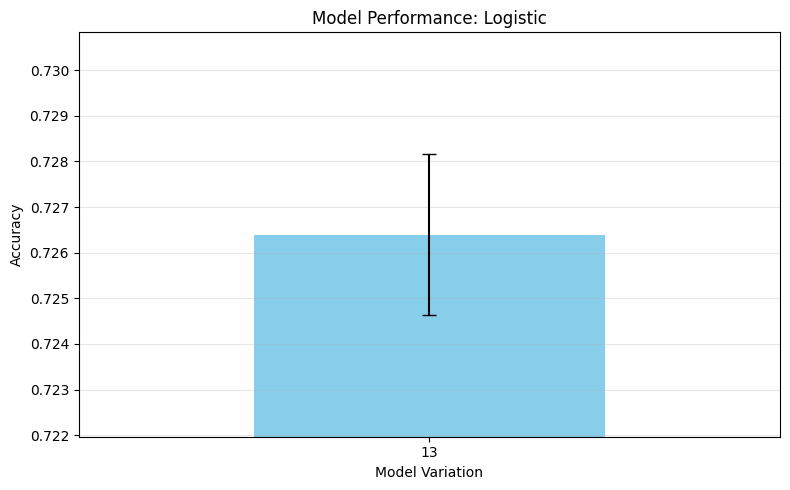

In [52]:
for alg, all_results_df in results.items():
    accuracy_means = all_results_df.loc['accuracy_mean']
    accuracy_stds = all_results_df.loc['accuracy_std']

    # Find the min and max values including the error bars
    min_y = (accuracy_means - accuracy_stds).min()
    max_y = (accuracy_means + accuracy_stds).max()
    
    # padding to top and bottom
    padding = (max_y - min_y) * 0.75
    y_axis_bottom = min_y - padding
    y_axis_top = max_y + padding
    # -------------------------------------

    # plot
    plt.figure(figsize=(8, 5))
    accuracy_means.plot(kind='bar', yerr=accuracy_stds, 
                        capsize=5, color=['skyblue', 'lightgreen', 'orange', 'salmon'])
    
    plt.title(f'Model Performance: {alg.capitalize()}')
    plt.ylabel('Accuracy')
    plt.xlabel('Model Variation')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    
    # Y-axis limits
    plt.ylim(y_axis_bottom, y_axis_top) # <-- This is the new line
    
    plt.tight_layout()
    plt.show()

Index(['model', 'model', 'model', 'model', 'mean_accuracy', 'std_dev'], dtype='object')